# Laboratorium 11 - Spadek wzdłuż gradientu

In [1]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

In [2]:
labels = pd.read_csv("breast-cancer.labels", header=None, names=["name"])
column_names = labels["name"].tolist()


train_data = pd.read_csv("breast-cancer-train.dat", header=None, names=column_names)
validate_data = pd.read_csv(
    "breast-cancer-validate.dat", header=None, names=column_names
)

In [3]:
# Reprezentacja liniowa
A_train_linear = train_data.drop(["patient ID", "Malignant/Benign"], axis=1).values
A_validate_linear = validate_data.drop(
    ["patient ID", "Malignant/Benign"], axis=1
).values

# Reprezentacja kwadratowa
selected_features = [
    "radius (mean)",
    "perimeter (mean)",
    "area (mean)",
    "symmetry (mean)",
]


def create_quadratic_features(data):
    quadratic_features = data[selected_features].copy()
    for feature in selected_features:
        quadratic_features[f"{feature}^2"] = data[feature] ** 2
    for i in range(len(selected_features)):
        for j in range(i + 1, len(selected_features)):
            feature1 = selected_features[i]
            feature2 = selected_features[j]
            quadratic_features[f"{feature1}*{feature2}"] = (
                data[feature1] * data[feature2]
            )
    return quadratic_features.values


A_train_quadratic = create_quadratic_features(train_data)
A_validate_quadratic = create_quadratic_features(validate_data)

In [4]:
# Wektor b dla zbioru treningowego
b_train = np.array([[1, 0] if row == "M" else [0, 1] for row in train_data["Malignant/Benign"]])

# Wektor b dla zbioru walidacyjnego
b_validate = np.array([[1, 0] if row == "M" else [0, 1] for row in validate_data["Malignant/Benign"]])

In [5]:
def softmax(Z):
    Z -= np.max(Z, axis=1).reshape(-1, 1)
    E = np.e ** Z
    SUM = np.sum(E, axis=1).reshape(-1, 1)
    P = E / SUM
    
    return P

In [6]:
def xentropy(S, T):
    n = len(S)
    return - (np.sum(T * np.log(S)) / n)

In [7]:
def grad_xentropy(X, S, T):
    n = len(S)
    return X.T @ (S - T) / n

In [8]:
def classify(W, X):
    sf_max = softmax(X @ W)
    return (sf_max == np.max(sf_max, axis=1, keepdims=True))

In [9]:
def calc_acc(P, T):
    accuracy = np.sum(P * T) / P.shape[0]
    return 100.0 * accuracy


def print_log(step, cost, train_acc, val_acc):
    log = 'Step {:3d}\tcost value: {:5.2f},\ttrain accuracy: {:5.2f},\t' \
          'validation accuracy: {:5.2f}'
    log = log.format(step, cost.item(), train_acc.item(), val_acc.item())
    
    print(log)


In [10]:
def gd_fit(W0, X, T, X_val, T_val, lr=1.0, steps=100, log_every=5):
    n = X.shape[0]
    W = np.copy(W0)
    M = 0
    mu = 0.9

    stats=[]
    
    for step in range(steps):
        sf_max = softmax(X @ W)
        cost_val = xentropy(sf_max, T)
        
        cost_grad = grad_xentropy(X, sf_max, T)
        M = mu * M - lr * cost_grad
        W = W + M
        
        P_train = classify(W, X)
        train_acc = calc_acc(P_train, T)
        
        P_val = classify(W, X_val)
        val_acc = calc_acc(P_val, T_val)
        
        if step == 0 or (step + 1) % log_every == 0:
            print_log(step+1, cost_val, train_acc, val_acc)
            stats.append((cost_val, train_acc, val_acc))

    
    return W, stats

In [11]:
ATA_eigenvalues, _ = np.linalg.eig(A_train_linear.T @ A_train_linear)
lambda_min = np.min(ATA_eigenvalues)
lambda_max = np.max(ATA_eigenvalues)
condition_no = lambda_max / lambda_min


In [12]:
X = np.column_stack([A_train_linear, np.full(A_train_linear.shape[0], 1)])
T = b_train
X_val = np.column_stack([A_validate_linear, np.full(A_validate_linear.shape[0], 1)])
T_val = b_validate

print(X.shape, T.shape, X_val.shape, T_val.shape)

(300, 31) (300, 2) (260, 31) (260, 2)


In [13]:
W0 = np.random.randn(31, 2)
W0 = np.zeros((31,2))
#print(X)
#print(W0)
#print(softmax(X @ W0))


Learning rate:  3e-05
Step   1	cost value:  0.69,	train accuracy: 48.67,	validation accuracy: 23.08
Step  10	cost value:  6.50,	train accuracy: 63.00,	validation accuracy: 80.77
Step  20	cost value:  8.67,	train accuracy: 86.00,	validation accuracy: 92.31
Step  30	cost value:  3.12,	train accuracy: 91.00,	validation accuracy: 90.38
Step  40	cost value:  1.45,	train accuracy: 85.33,	validation accuracy: 73.46
Step  50	cost value:  0.59,	train accuracy: 84.00,	validation accuracy: 73.46
Step  60	cost value:  0.57,	train accuracy: 91.67,	validation accuracy: 83.08
Step  70	cost value:  0.48,	train accuracy: 92.33,	validation accuracy: 87.69
Step  80	cost value:  0.42,	train accuracy: 92.33,	validation accuracy: 87.31
Step  90	cost value:  0.38,	train accuracy: 92.33,	validation accuracy: 88.08
Step 100	cost value:  0.35,	train accuracy: 91.67,	validation accuracy: 89.62
Step 110	cost value:  0.33,	train accuracy: 91.33,	validation accuracy: 89.62
Step 120	cost value:  0.32,	train accuracy

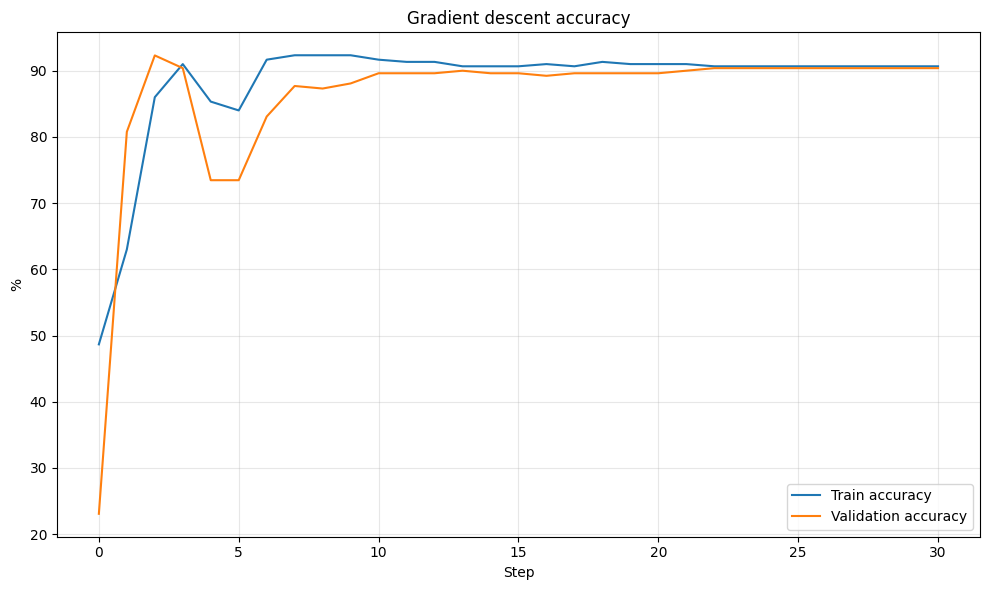

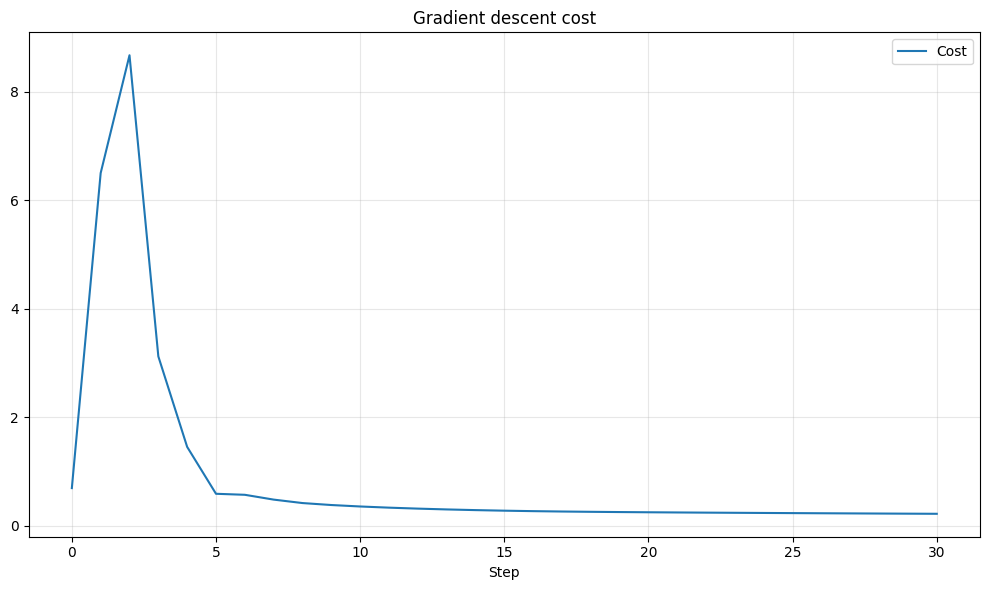

In [14]:
# Another try with higher learning rate
# lr = 2 / (lambda_max + lambda_min)
lr = 0.00003
print("Learning rate: ", lr)
W, stats = gd_fit(W0, X, T, X_val, T_val, lr=lr, steps = 300, log_every=10)


cost = [t[0] for t in stats]
t_acc = [t[1] for t in stats]
v_acc = [t[2] for t in stats]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each series
plt.plot(t_acc, label='Train accuracy')
plt.plot(v_acc, label='Validation accuracy')

# Customize the plot
plt.xlabel('Step')
plt.ylabel('%')
plt.title('Gradient descent accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()


# Create the plot
plt.figure(figsize=(10, 6))

# Plot each series
plt.plot(cost, label='Cost')

# Customize the plot
plt.xlabel('Step')
plt.title('Gradient descent cost')
plt.legend()
plt.grid(True, alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()